In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['font.size']=18
rcParams['figure.figsize'] = (12,8)

In [3]:
import kid_readout.analysis.archive

/home/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


no data directory set up for artemis.phys.columbia.edu defaulting to /data
updated file list


#Data with source attenuated so much that it's basically off

In [4]:
pkls_low_power = kid_readout.analysis.archive.load_noise_pkl('/data/readout/pkl/2015-05-19_101902_mmw_continuous-wave_148_GHz.pkl')

#Data with source in continuous wave mode at high power

In [5]:
pkls_high_power_cw = kid_readout.analysis.archive.load_noise_pkl('/data/readout/pkl/2015-05-20_105213_mmw_continuous-wave_148_GHz.pkl')

#Data with source in broadband mode at high power

In [6]:
pkls_high_power_wide = kid_readout.analysis.archive.load_noise_pkl('/data/readout/pkl/2015-05-13_154402_mmw_noise_broadband.pkl')

#Select data with probe tone powers such that amplifier noise floor is similar

In [7]:
high_cw = [nm for nm in pkls_high_power_cw if nm.atten==26]
high_wide = [nm for nm in pkls_high_power_wide if nm.atten==29]
low_cw  = [nm for nm in pkls_low_power if nm.atten==35]

In [8]:
for cw,wide,off in zip(high_cw,high_wide,low_cw):
    print cw.resonator_index,cw.fit_params['f_0'].value,wide.fit_params['f_0'].value,off.fit_params['f_0'].value

0 96.0357088524 96.0470742485 96.0672251167
1 101.888427971 101.912927971 101.964821424
2 108.834228482 108.847230398 108.867047333
3 112.188444376 112.219206551 112.264902608
4 117.24094569 117.253476909 117.274814212
5 127.694802484 127.726713849 127.789056214
6 195.617605745 195.641476026 195.716762029
7 188.74778203 188.794263266 188.867178621
8 184.419826923 184.465749444 184.558413904
9 178.842794198 178.870812158 178.945564279
10 174.824651657 174.871685805 174.960242726
11 165.361105922 165.380844382 165.412588188
12 164.260009154 164.299769648 164.37875648
13 163.965047553 164.010380497 164.087564485
14 148.170433516 148.198644529 148.249637085
15 144.105334282 144.136761998 144.192462486


#Have a look at some spectra

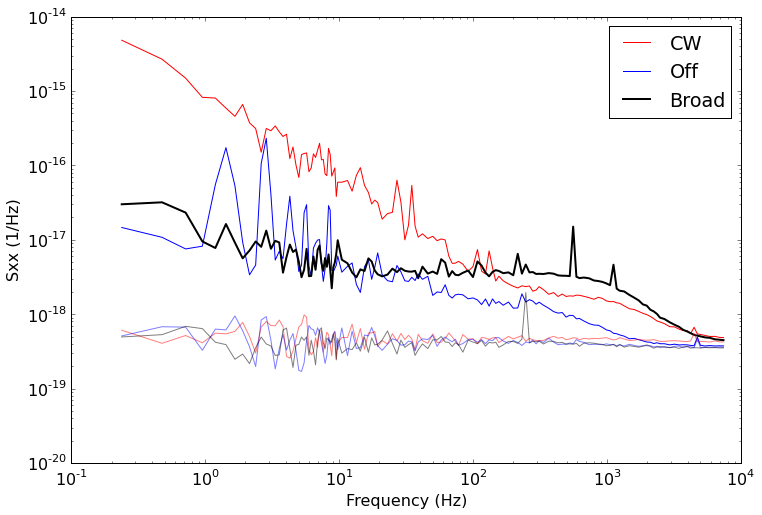

In [9]:
loglog(high_cw[0].pca_freq,high_cw[0].pca_eigvals[1,:],color='r',label='CW')
loglog(low_cw[0].pca_freq,low_cw[0].pca_eigvals[1,:],color='blue',label='Off')
loglog(high_cw[0].pca_freq,high_wide[0].pca_eigvals[1,:],color='black',lw=2,label='Broad')
loglog(high_cw[0].pca_freq,high_cw[0].pca_eigvals[0,:],color='r',alpha=0.5)
loglog(low_cw[0].pca_freq,low_cw[0].pca_eigvals[0,:],color='blue',alpha=0.5)
loglog(high_cw[0].pca_freq,high_wide[0].pca_eigvals[0,:],color='black',alpha=0.5)
legend()
ylabel('Sxx (1/Hz)')
xlabel('Frequency (Hz)')

In [10]:
import kid_readout.analysis.cross_spectrum
reload(kid_readout.analysis.cross_spectrum)

<module 'kid_readout.analysis.cross_spectrum' from '/home/gjones/readout/kid_readout/kid_readout/analysis/cross_spectrum.pyc'>

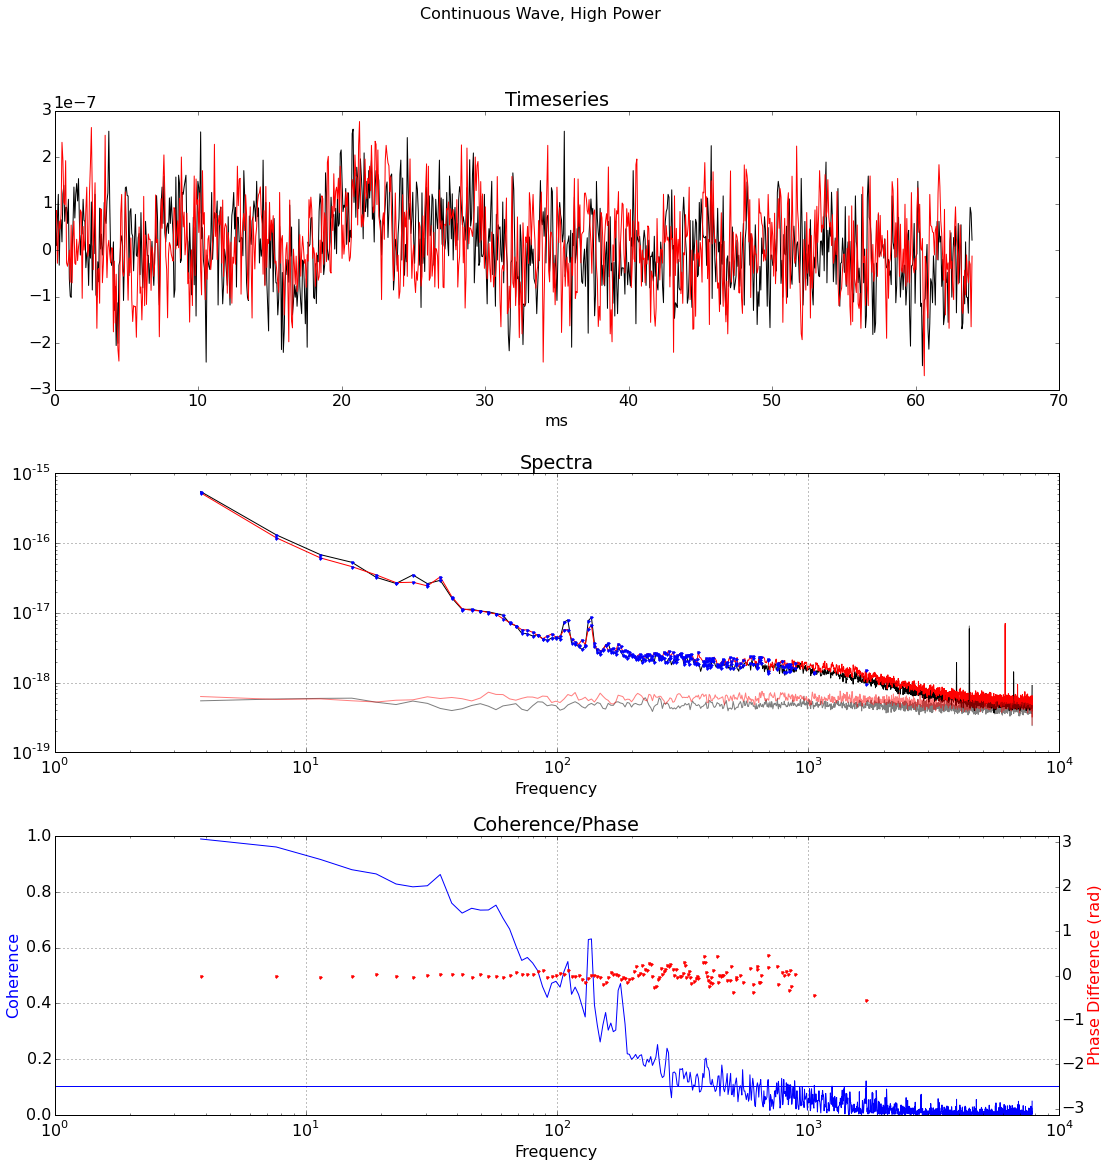

In [11]:
cs = kid_readout.analysis.cross_spectrum.CrossSpectralAnalysis(high_cw[0],high_cw[2])
cs.calculate(2**12,thresh=0.999)
cs.plot()
suptitle('Continuous Wave, High Power')

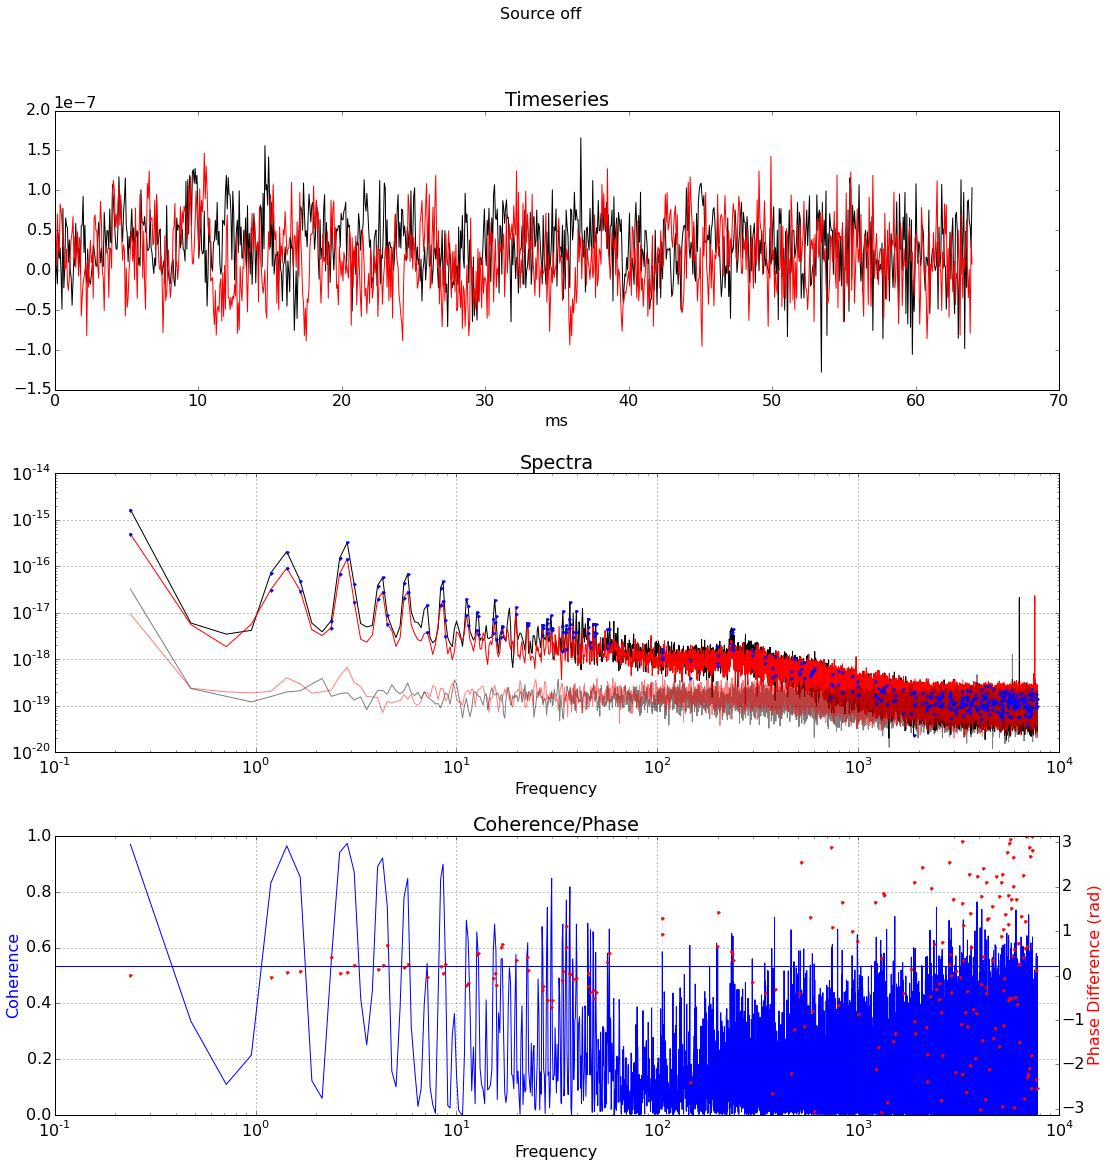

In [12]:
cs = kid_readout.analysis.cross_spectrum.CrossSpectralAnalysis(low_cw[4],low_cw[2])
cs.calculate(2**16,thresh=0.9)
cs.plot()
suptitle('Source off')

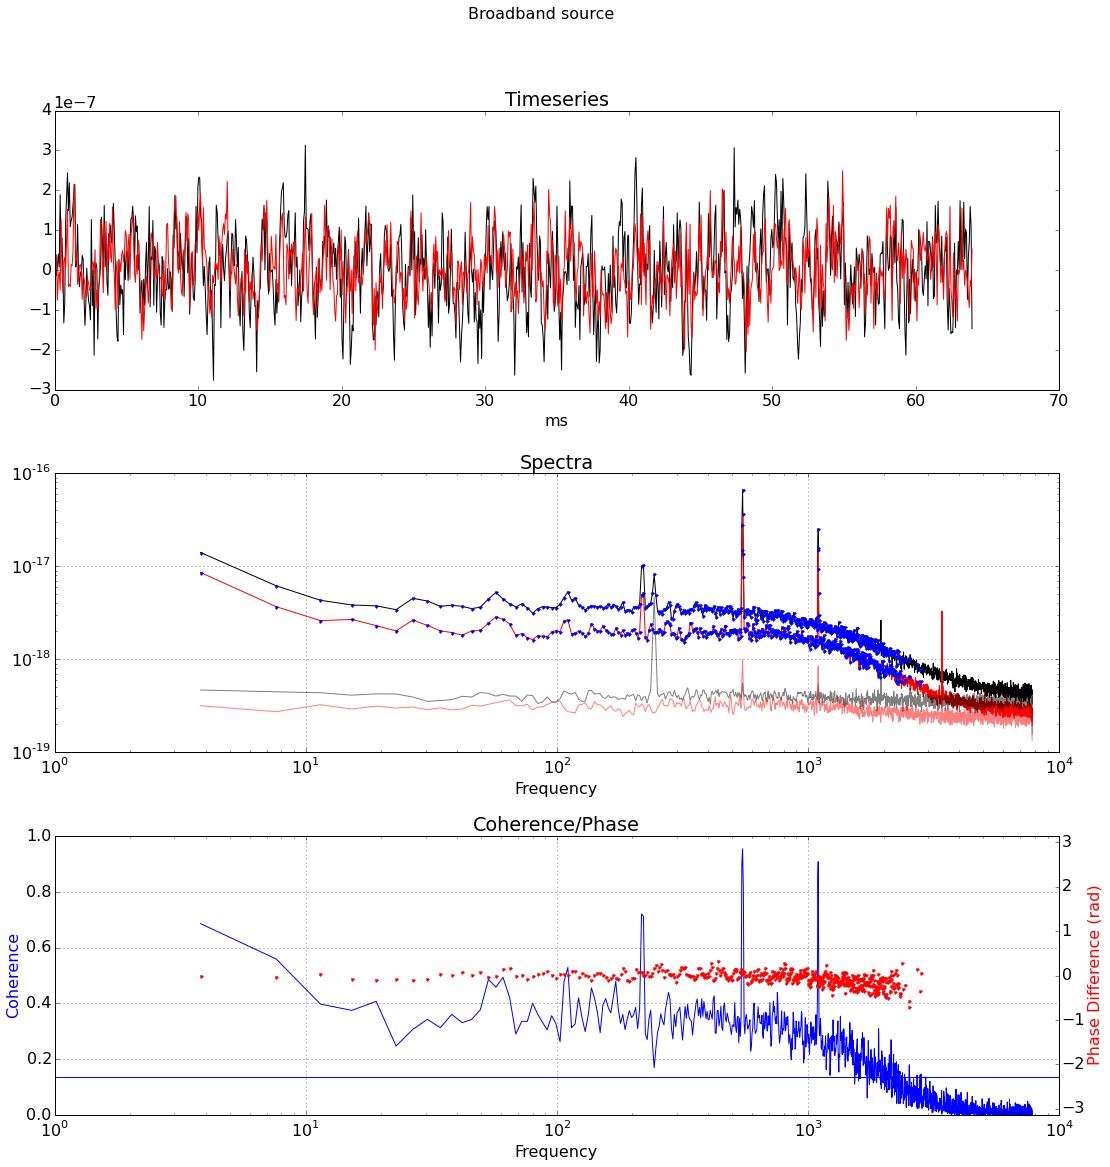

In [13]:
cs = kid_readout.analysis.cross_spectrum.CrossSpectralAnalysis(high_wide[0],high_wide[2])
cs.calculate(2**12,thresh=0.9999)
cs.plot()
suptitle('Broadband source')

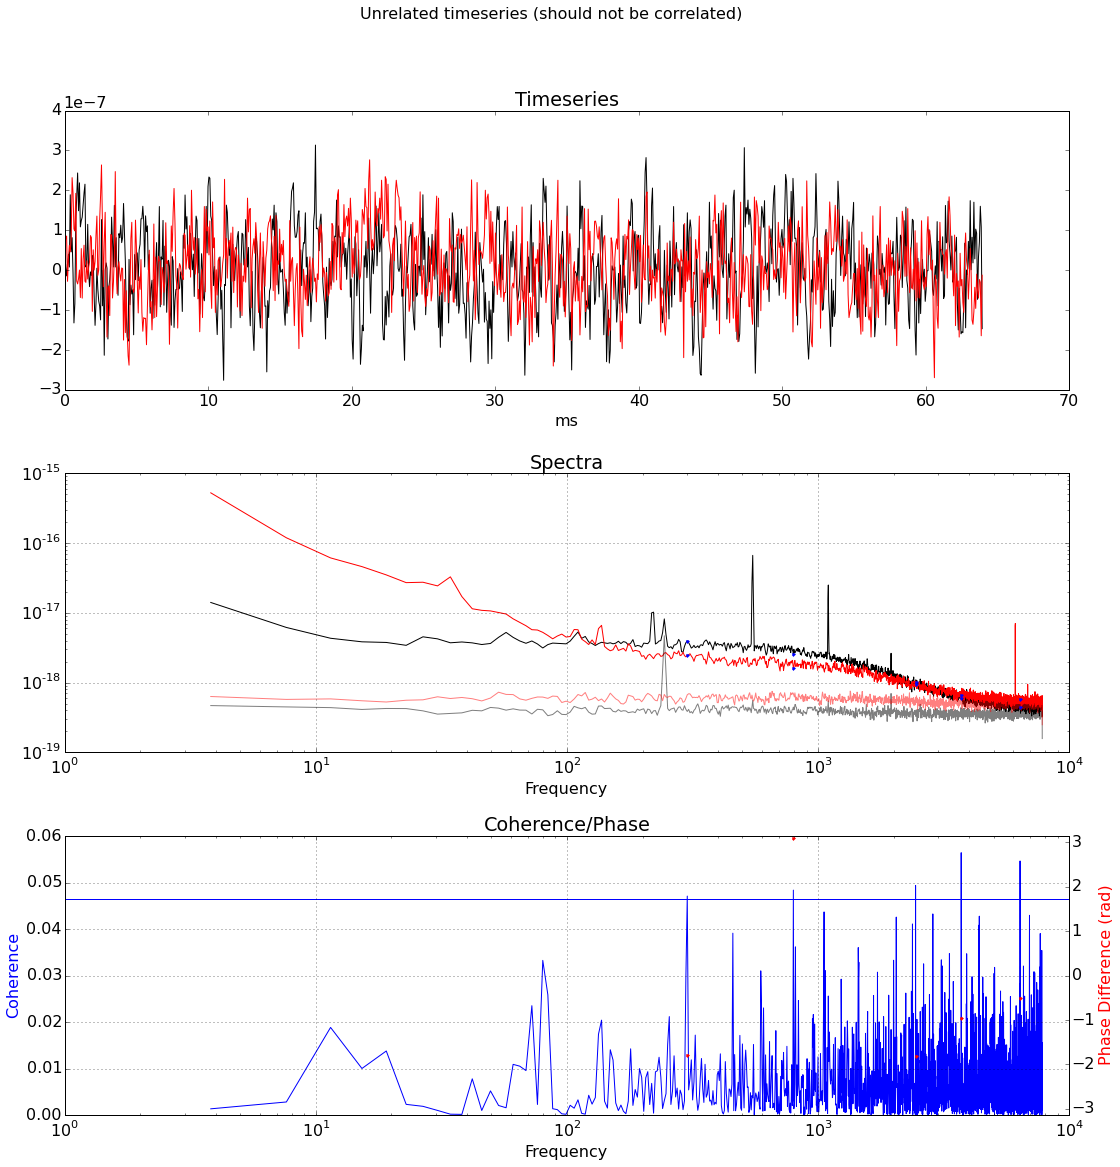

In [14]:
cs = kid_readout.analysis.cross_spectrum.CrossSpectralAnalysis(high_wide[0],high_cw[2])
cs.calculate(2**12)
cs.plot()
suptitle('Unrelated timeseries (should not be correlated)')

#Crude attempt at subtracting out red noise contribution
##More work to be done

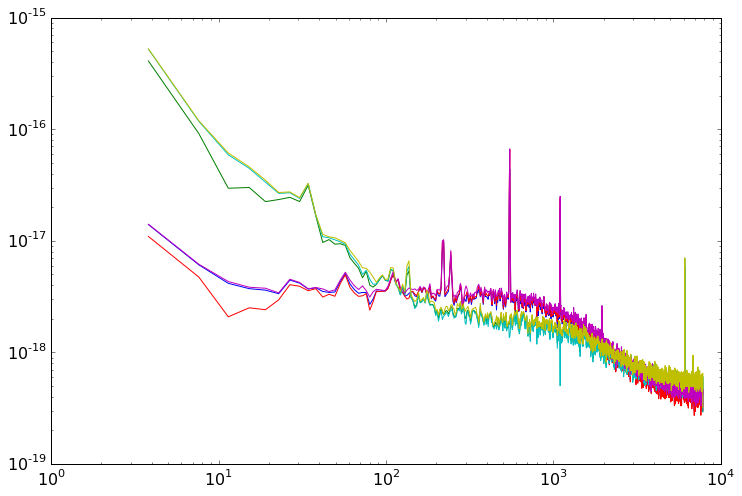

In [15]:
#loglog(cs.coh_freq,np.abs(cs.csd))
loglog(cs.freq,cs.pxx1-(np.abs(cs.csd)*cs.pxx1/cs.pxx2))
loglog(cs.freq,cs.pxx2-(np.abs(cs.csd)*cs.pxx2/cs.pxx1))
loglog(cs.freq,cs.pxx1-(np.abs(cs.csd)))
loglog(cs.freq,cs.pxx2-(np.abs(cs.csd)))
loglog(cs.freq,cs.pxx1)
loglog(cs.freq,cs.pxx2)


#Cross correlating all detectors
##Daniel says the resonators I picked above might actually be dark (horns covered with tape)

In [17]:
ccx_wide = []
for x in range(16):
    for y in range(x+1,16):
        cc = kid_readout.analysis.cross_spectrum.CrossSpectralAnalysis(high_wide[x],high_wide[y])
        cc.calculate(NFFT=2**12)
        ccx_wide.append(cc)

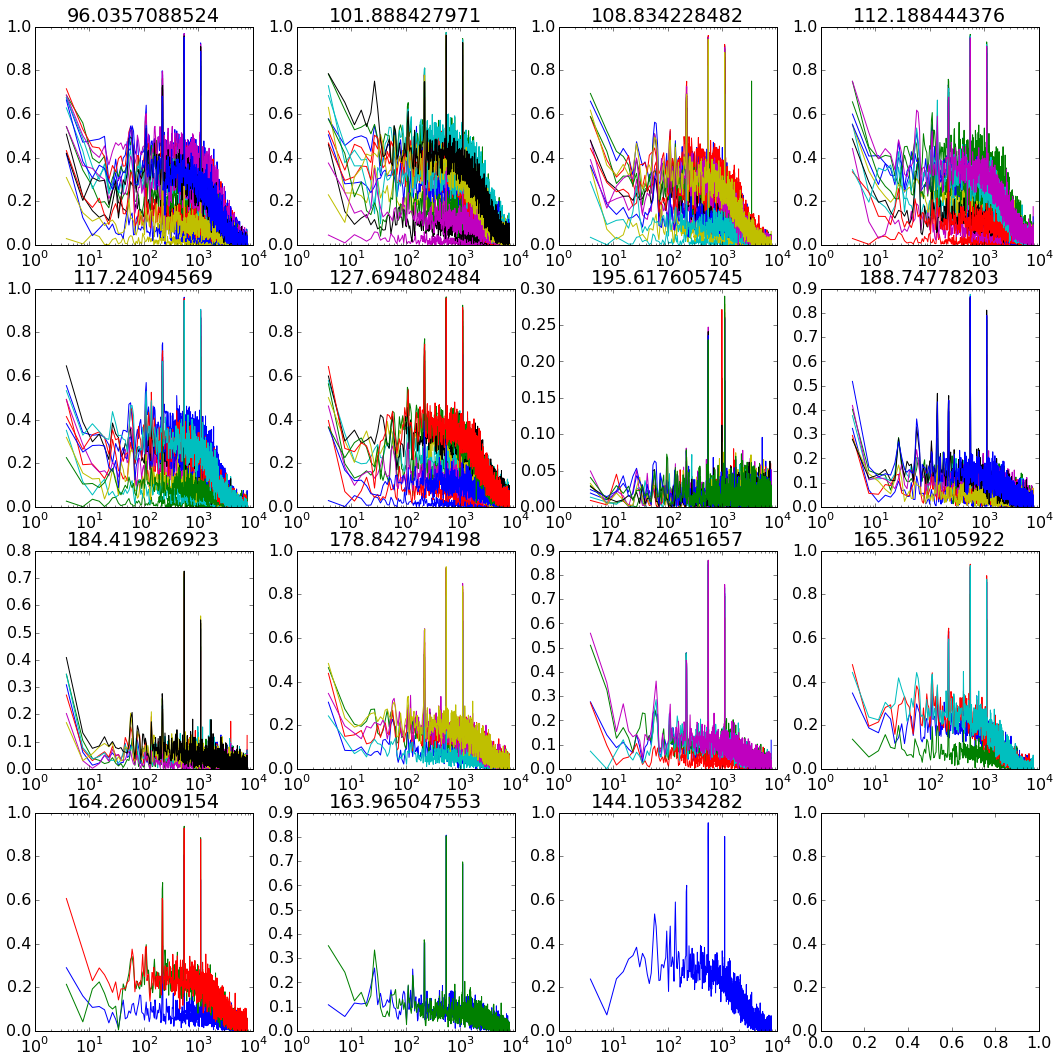

In [43]:
fig,axs = plt.subplots(4,4,figsize=(18,18))
xc = np.zeros((16,16))
k = 0
for x in range(16):
    for y in range(x+1,16):
        cc = ccx_wide[k]
        ax = axs.flatten()[x]
        ax.semilogx(cc.coh_freq,cc.coherence)
        
#        xc[x,y] = np.median(cc.coherence[:20])
        k += 1
    ax.set_title(high_cw[x].fit_params['f_0'].value)

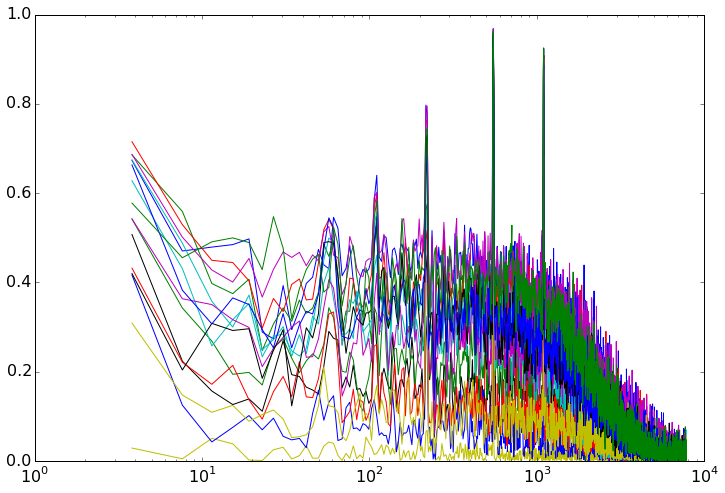

In [21]:
for k in range(16):
    cc = ccx_wide[k]
    semilogx(cc.coh_freq,cc.coherence)

In [22]:
ccx_cw = []
for x in range(16):
    for y in range(x+1,16):
        cc = kid_readout.analysis.cross_spectrum.CrossSpectralAnalysis(high_cw[x],high_cw[y])
        cc.calculate(NFFT=2**12)
        ccx_cw.append((x,y,cc))

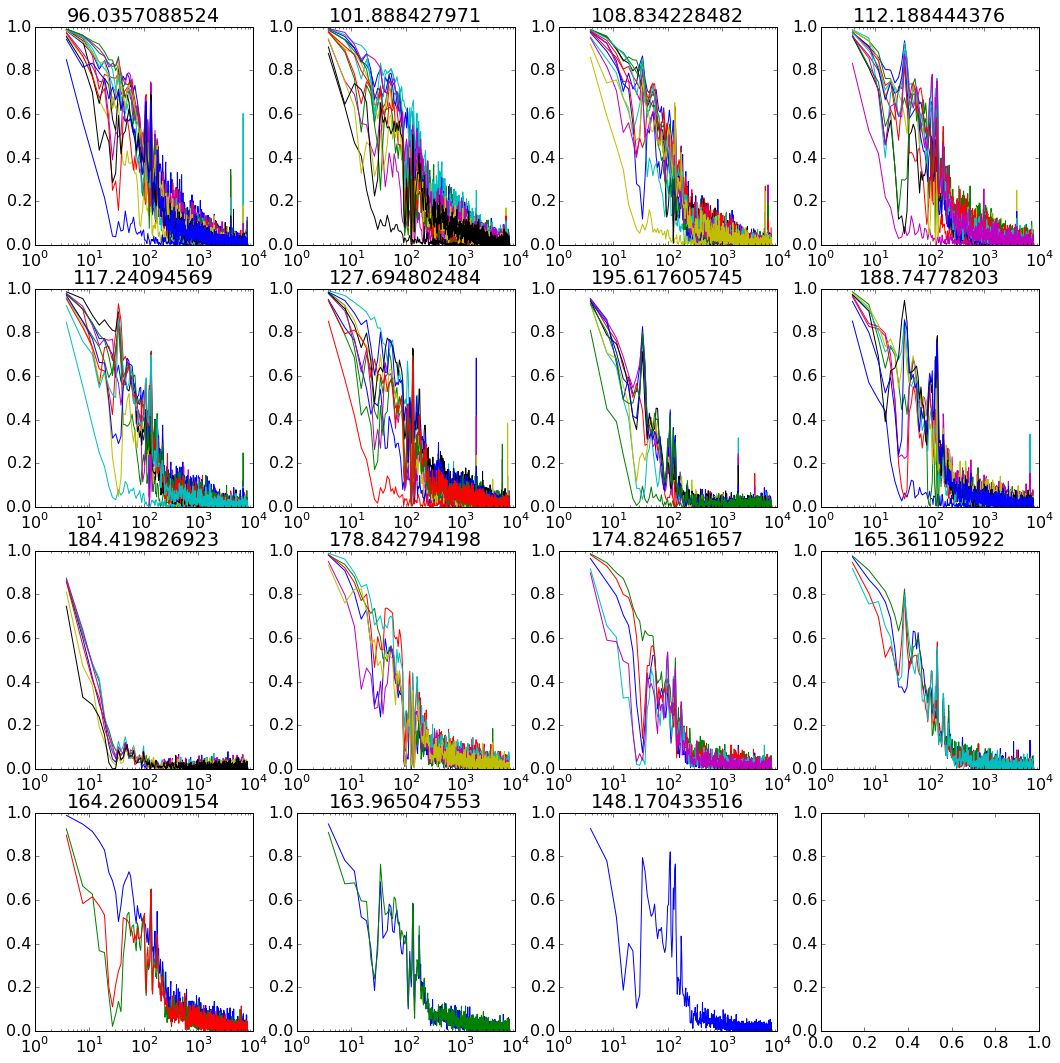

In [44]:
fig,axs = plt.subplots(4,4,figsize=(18,18))
xc = np.zeros((16,16))
k = 0
for x in range(16):
    for y in range(x+1,16):
        xx,yy,cc = ccx_cw[k]
        ax = axs.flatten()[x]
        ax.semilogx(cc.coh_freq,cc.coherence)
#        xc[x,y] = np.median(cc.coherence[:20])
        k += 1
    ax.set_title(high_cw[xx].fit_params['f_0'].value)

In [24]:
ccx_off = []
for x in range(16):
    for y in range(x+1,16):
        cc = kid_readout.analysis.cross_spectrum.CrossSpectralAnalysis(low_cw[x],low_cw[y])
        #cc.calculate(NFFT=2**12)
        ccx_off.append((x,y,cc))

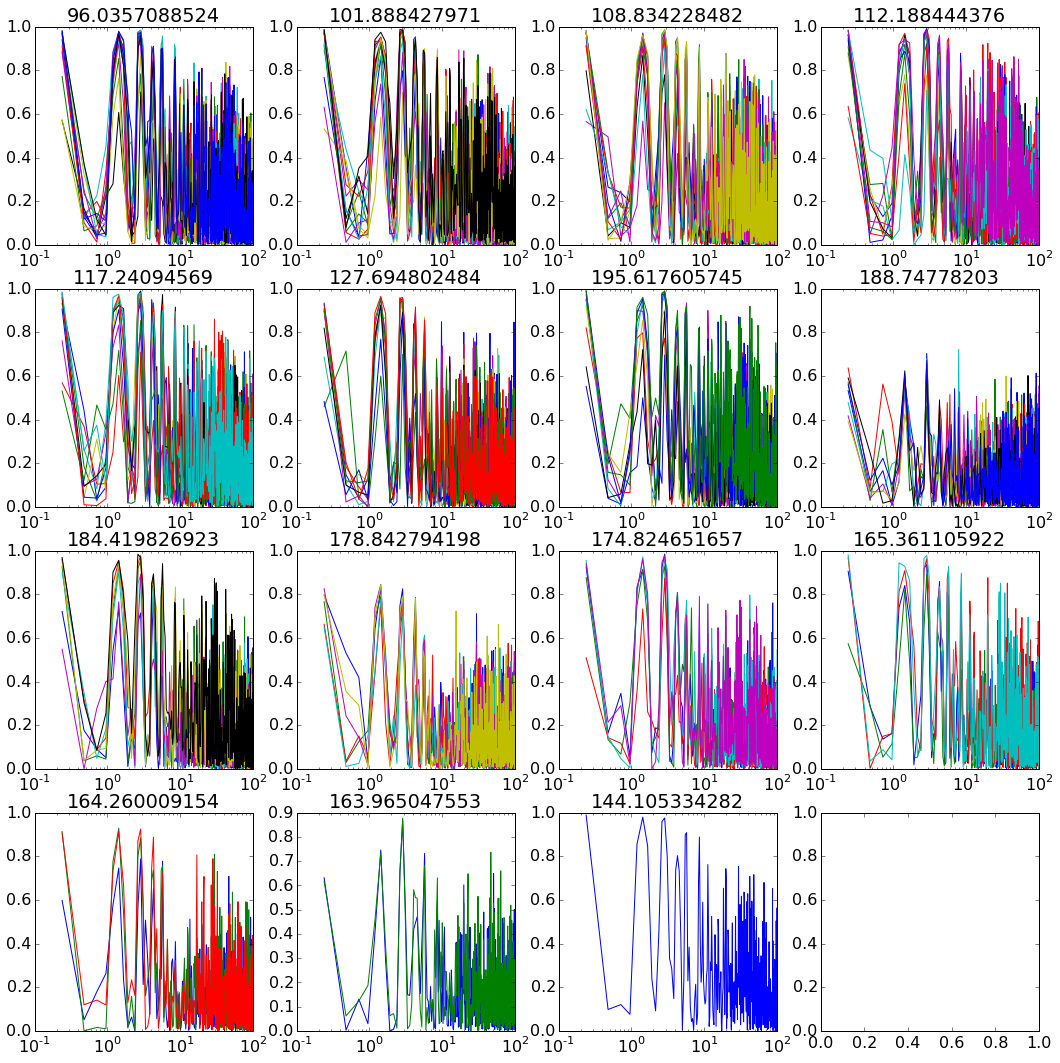

In [45]:
fig,axs = plt.subplots(4,4,figsize=(18,18))
xc = np.zeros((16,16))
k = 0
for x in range(16):
    for y in range(x+1,16):
        xx,yy,cc = ccx_off[k]
        ax = axs.flatten()[x]
        ax.semilogx(cc.coh_freq,cc.coherence)
#        xc[x,y] = np.median(cc.coherence[:20])
        k += 1
    ax.set_title(high_cw[x].fit_params['f_0'].value)
    ax.set_xlim(1e-1,100)

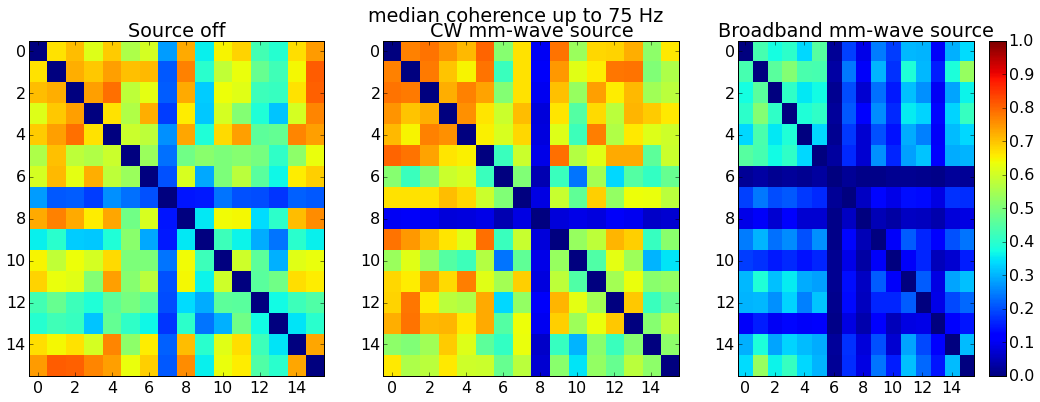

In [40]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
xc = np.zeros((16,16))
k = 0
for x in range(16):
    for y in range(x+1,16):
        x,y,cc = ccx_cw[k]
        xc[x,y] = np.median(cc.coherence[:20])
        k += 1
xc = xc + xc.T        
ax2.imshow(xc,aspect='auto',interpolation='nearest',clim=(0,1))
ax2.set_title('CW mm-wave source')

xc = np.zeros((16,16))
k = 0
for x in range(16):
    for y in range(x+1,16):
        x,y,cc = ccx_off[k]
        xc[x,y] = np.median(cc.coherence[:20])
        k += 1
xc = xc + xc.T
ax1.imshow(xc,aspect='auto',interpolation='nearest',clim=(0,1))
ax1.set_title('Source off')

xc = np.zeros((16,16))
k = 0
for x in range(16):
    for y in range(x+1,16):
        cc = ccx_wide[k]
        xc[x,y] = np.median(cc.coherence[:20])
        k += 1
xc = xc + xc.T
im = ax3.imshow(xc,aspect='auto',interpolation='nearest',clim=(0,1))
ax3.set_title('Broadband mm-wave source')
colorbar(im)
fig.suptitle('median coherence up to 75 Hz',size='large')